# Data Loading

In [170]:
path1 = "Dataset/gauravduttakiit/banknote/versions/1"

print("Path to dataset files:", path1)


TRAIN_PATH = path1 + "/train.csv"
TEST_PATH = path1 + "/test.csv"

Path to dataset files: Dataset/gauravduttakiit/banknote/versions/1


In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

In [172]:
df = pd.read_csv(TRAIN_PATH)

In [173]:
df.head()

,VWTI,SWTI,CWTI,EI,Class
0,2.2634,-4.4862,3.6558,-0.612510,0
1,3.2718,1.7837,2.1161,0.613340,0
2,-3.9411,-12.8792,13.0597,-3.312500,1
3,0.5195,-3.2633,3.0895,-0.984900,0
4,2.5698,-4.4076,5.9856,0.078002,0


In [174]:
X = df.drop(columns=['Class'])
y = df['Class']

# Обучение модели

## Бозовая модель

In [175]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
baseline_model = RandomForestClassifier()
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_valid)

In [177]:
acc = accuracy_score(y_valid, y_pred_base)
prec = precision_score(y_valid, y_pred_base)
rec = recall_score(y_valid, y_pred_base)

In [178]:
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)


Accuracy: 0.990909090909091
Precision: 0.9770114942528736
Recall: 1.0


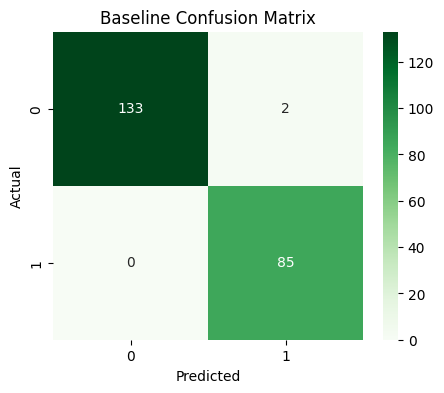

In [179]:
cm = confusion_matrix(y_valid, y_pred_base)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Confusion Matrix')
plt.show()

## Улучшенная модель

In [180]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [181]:
best_acc = 0
best_model = None
best_params = None


for trees in [50, 100, 150, 200]:
    for depth in [None, 5, 7, 10, 15]:
        model = RandomForestClassifier(n_estimators=trees, max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        score = accuracy_score(y_valid, preds)
        if score > best_acc:
            best_acc = score
            best_model = model
            best_params = (trees, depth)

In [182]:
print(best_params)

(50, None)


In [183]:
y_pred_imp = best_model.predict(X_valid)
acc2 = accuracy_score(y_valid, y_pred_imp)
prec2 = precision_score(y_valid, y_pred_imp)
rec2 = recall_score(y_valid, y_pred_imp)
f12 = f1_score(y_valid, y_pred_imp)
auc2 = roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:,1])

In [184]:
print("Accuracy:", acc2)
print("Precision:", prec2)
print("Recall:", rec2)

Accuracy: 0.9969604863221885
Precision: 0.9931972789115646
Recall: 1.0


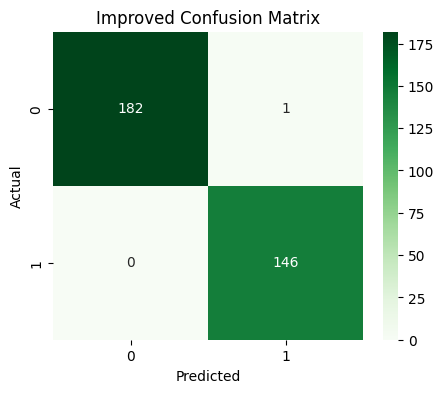

In [185]:
cm2 = confusion_matrix(y_valid, y_pred_imp)
plt.figure(figsize=(5,4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Improved Confusion Matrix')
plt.show()

Метрики стали чуть лучше после изменения гиперпараметров

##  Реализованная модель

In [251]:
def gini_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return 1 - np.sum(probs ** 2)

class RFNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class SimpleDecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.root = None

    def build(self, X, y, depth):
        # Base case: create leaf node
        if (depth >= self.max_depth or 
            len(y) < self.min_samples_split or 
            gini_impurity(y) == 0):
            values, counts = np.unique(y, return_counts=True)
            return RFNode(value=values[np.argmax(counts)])
        
        # Select random subset of features
        n_features = X.shape[1]
        features = np.random.choice(
            n_features, 
            size=min(self.max_features, n_features), 
            replace=False
        )
        
        best_gini = float('inf')
        best_feature = None
        best_threshold = None
        
        # Evaluate all possible splits
        for feature in features:
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left_mask = X[:, feature] <= t
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                left_y = y[left_mask]
                right_y = y[right_mask]
                
                g_left = gini_impurity(left_y)
                g_right = gini_impurity(right_y)
                
                weighted_gini = (len(left_y) / len(y)) * g_left + \
                               (len(right_y) / len(y)) * g_right
                
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = t

        if best_feature is None:
            values, counts = np.unique(y, return_counts=True)
            return RFNode(value=values[np.argmax(counts)])
        
        left_mask = X[:, best_feature] <= best_threshold
        left = self.build(X[left_mask], y[left_mask], depth + 1)
        right = self.build(X[~left_mask], y[~left_mask], depth + 1)
        
        return RFNode(best_feature, best_threshold, left, right)

    def fit(self, X, y):
        self.root = self.build(X, y, 0)
    
    def predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.predict_one(x, node.left)
        else:
            return self.predict_one(x, node.right)
    
    def predict(self, X):
        return np.array([self.predict_one(x, self.root) for x in X])

class RandomForestScratch:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=2, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def bootstrap_sample(self, X, y):
        idx = np.random.choice(len(X), len(X), replace=True)
        return X[idx], y[idx]

    def fit(self, X, y):
        self.trees = []
        # Set default max_features if not specified
        if self.max_features is None:
            self.max_features = int(np.sqrt(X.shape[1]))
        
        for _ in range(self.n_estimators):
            X_s, y_s = self.bootstrap_sample(X, y)
            tree = SimpleDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features
            )
            tree.fit(X_s, y_s)
            self.trees.append(tree)

    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees])
        final = []

        for i in range(len(X)):
            vals, counts = np.unique(preds[:, i], return_counts=True)
            final.append(vals[np.argmax(counts)])

        final = np.array(final, dtype=int)
        return final

## Базовая реализованная модель

In [252]:
X_train_np = X_train.values
y_train_np = y_train.values
X_valid_np = X_valid.values
y_valid_np = y_valid.values

In [253]:
rf_scratch = RandomForestScratch()
rf_scratch.fit(X_train_np, y_train_np)
y_pred_scratch = rf_scratch.predict(X_valid_np)

y_pred_scratch = y_pred_scratch.astype(int)

In [254]:
acc_s = accuracy_score(y_valid_np, y_pred_scratch)
prec_s = precision_score(y_valid_np, y_pred_scratch)
rec_s = recall_score(y_valid_np, y_pred_scratch)

ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

# Data loading

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [187]:
DATA_PATH = "Dataset/Water/water_consumption.csv"

In [188]:
df = pd.read_csv(DATA_PATH)

In [189]:
df.head()

,Country,Year,Total Water Consumption (Billion Cubic Meters),Per Capita Water Use (Liters per Day),Agricultural Water Use (%),Industrial Water Use (%),Household Water Use (%),Rainfall Impact (Annual Precipitation in mm),Groundwater Depletion Rate (%),Water Scarcity Level
0,Argentina,2000,481.490000,235.431429,48.550000,20.844286,30.100000,1288.698571,3.255714,Moderate
1,Argentina,2001,455.063000,299.551000,48.465000,26.943000,22.550000,1371.729000,3.120000,Moderate
2,Argentina,2002,482.749231,340.124615,50.375385,29.042308,23.349231,1590.305385,2.733846,Moderate
3,Argentina,2003,452.660000,326.756667,49.086667,30.476000,24.440000,1816.012667,2.708000,Moderate
4,Argentina,2004,634.566000,230.346000,38.670000,36.670000,23.924000,815.998000,1.902000,Moderate


In [190]:
df = df.rename(columns={
"Country": "country",
"Year": "year",
"Total Water Consumption (Billion Cubic Meters)": "total_consumption",
"Per Capita Water Use (Liters per Day)": "per_capita_use",
"Agricultural Water Use (%)": "agricultural_use",
"Industrial Water Use (%)": "industrial_use",
"Household Water Use (%)": "household_use",
"Rainfall Impact (Annual Precipitation in mm)": "rainfall",
"Groundwater Depletion Rate (%)": "groundwater_depletion",
"Water Scarcity Level": "scarcity_level"
})

# Обучение модели

Подготовка к обучению

In [191]:
df_sorted = df.sort_values('year')
train = df_sorted[df_sorted.year < df_sorted.year.max() - 2]
valid = df_sorted[df_sorted.year >= df_sorted.year.max() - 2]

Обучение модели

In [192]:
X_train = train.drop(columns=['total_consumption'])
y_train = train['total_consumption']
X_valid = valid.drop(columns=['total_consumption'])
y_valid = valid['total_consumption']

In [193]:
numeric = X_train.select_dtypes(include=[np.number]).columns
categorical = X_train.select_dtypes(include=[object]).columns

## Базовая модель

In [194]:
baseline_preprocessor = ColumnTransformer([
("onehot", OneHotEncoder(handle_unknown='ignore'), categorical)
], remainder='passthrough')

In [195]:
baseline_model = Pipeline([
("prep", baseline_preprocessor),
("rf", RandomForestRegressor())
])

In [196]:
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_valid)

In [197]:
mae_base = mean_absolute_error(y_valid, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_valid, y_pred_base))
r2_base = r2_score(y_valid, y_pred_base)
mae_percent_base = mae_base / y_valid.mean() * 100

In [198]:
print("MAE:", mae_base)
print("RMSE:", rmse_base)
print("R2:", r2_base)
print("MAE%:", mae_percent_base)

MAE: 80.75258767533325
RMSE: 108.1675029287193
R2: -0.24825798446600755
MAE%: 16.33219713256843


In [199]:
best_mae = 1e18
best_model = None
best_params = None


for trees in [100, 200, 300]:
    for depth in [None, 5, 8, 12]:
        for leaf in [1, 2, 4]:
            model = Pipeline([
            ("prep", baseline_preprocessor),
            ("rf", RandomForestRegressor(
            n_estimators=trees,
            max_depth=depth,
            min_samples_leaf=leaf,
            random_state=42
            ))
        ])
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        mae = mean_absolute_error(y_valid, preds)
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_params = (trees, depth, leaf)

In [200]:
print("\nBest parameters:", best_params)


Best parameters: (100, 5, 4)


In [201]:
y_pred_imp = best_model.predict(X_valid)
mae_imp = mean_absolute_error(y_valid, y_pred_imp)
rmse_imp = np.sqrt(mean_squared_error(y_valid, y_pred_imp))
r2_imp = r2_score(y_valid, y_pred_imp)
mae_percent_imp = mae_imp / y_valid.mean() * 100

In [202]:
print("MAE:", mae_imp)
print("RMSE:", rmse_imp)
print("R2:", r2_imp)
print("MAE%:", mae_percent_imp)

MAE: 76.70608311635138
RMSE: 102.19139188711401
R2: -0.11413899159953411
MAE%: 15.513792273261167
